In [1]:
from astropy.io import fits as pyfits, ascii as asc
from astropy.table import Table
from create_ordered_AP_arrays import create_ordered_AP_arrays
import numpy as np, matplotlib.pyplot as plt
import plotting.general_plotting as general_plotting
import plotting_NII_Ha_ratios

from analysis.cardelli import *
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
from scipy.interpolate import interp1d
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)


FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

## dual ha/oii/oiii nb704/nb711 emitters

In [2]:
# reading in data
nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
allcols = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fits')
# allcolsdata0 = allcols[1].data
allcolsdata = allcols[1].data
NAME0 = np.array(nbiadata['NAME'])
ID0   = np.array(nbiadata['ID'])
zspec = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,
                 Reader=asc.CommentedHeader)
zspec0 = np.array(zspec['zspec0'])
inst_str0 = np.array(zspec['inst_str0'])
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])
data_dict = create_ordered_AP_arrays()
AP = data_dict['AP']
HA_FLUX   = data_dict['HA_FLUX']
HB_FLUX   = data_dict['HB_FLUX']
HB_SNR    = data_dict['HB_SNR']
NIIB_FLUX = data_dict['NIIB_FLUX']
NIIB_SNR  = data_dict['NIIB_SNR']


# defining other useful data structs
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
inst_dict = {}
inst_dict['MMT']  = ['MMT,FOCAS,','MMT,','merged,','MMT,Keck,']
inst_dict['Keck'] = ['merged,','Keck,','Keck,Keck,','Keck,FOCAS,','Keck,FOCAS,FOCAS,','Keck,Keck,FOCAS,']


nb704_response = asc.read(FULL_PATH+'Filters/NB704response.dat',guess=False,
                          Reader=asc.NoHeader)
nb711_response = asc.read(FULL_PATH+'Filters/NB711response.dat',guess=False,
                          Reader=asc.NoHeader)
filter_stat_corr_dict = {'NB704':1.289439104, 'NB711':1.41022358406, 
                         'NB816':1.29344789854, 'NB921':1.32817034288, 'NB973':1.29673596942}

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
### creating ordered LMIN0/LMAX0 arrs
### done creating ordered LMIN0/LMAX0 arr
### creating ordered SNR arrs
### done creating ordered SNR arrs
### creating ordered FLUX arrs
### done creating ordered FLUX arrs


In [3]:
dual = np.array([x for x in range(len(NAME0)) if 
                 (('Ha-NB704' in NAME0[x] and 'Ha-NB711' in NAME0[x]) or 
                  ('OII-NB704' in NAME0[x] and 'OII-NB711' in NAME0[x]) or 
                  ('OIII-NB704' in NAME0[x] and 'OIII-NB711' in NAME0[x])) and
                 (NAME0[x] != 'OIII-NB704_007153_OIII-NB711_006818' 
                  and NAME0[x] != 'OIII-NB704_018532_OIII-NB711_016028'
                  and NAME0[x] != 'OIII-NB704_022868_OIII-NB711_019473')]) # excluding cases w/ rare HB contamination

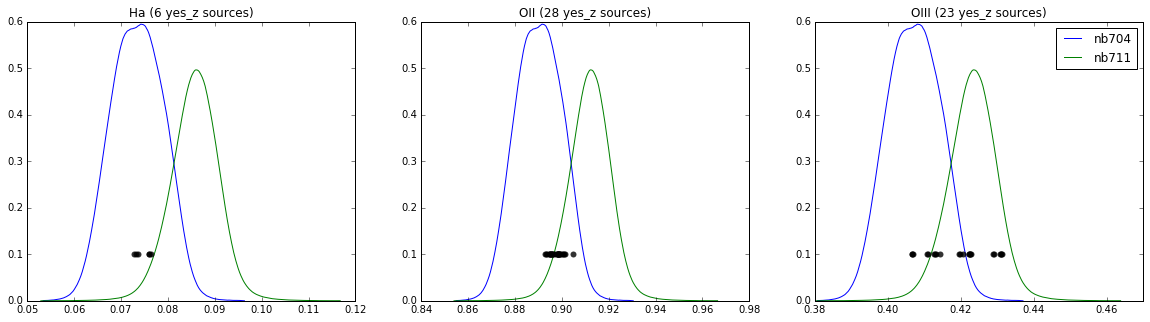

In [4]:
f, ax = plt.subplots(1,3)
for i, line, ltitle in zip(range(3), [6562.8, 3727.0, 5006.8], ['Ha', 'OII', 'OIII']):
    z_filt = nb704_response['col1'].data/line - 1
    yresponse = np.array(nb704_response['col2'])
    ax[i].plot(z_filt, yresponse, label='nb704')
    
    z_filt2 = nb711_response['col1'].data/line - 1
    yresponse2 = np.array(nb711_response['col2'])
    ax[i].plot(z_filt2, yresponse2, label='nb711')
    
    lmatch = np.array([x for x in range(len(dual)) if ltitle+'-NB7' in NAME0[dual][x]])
    yz = lmatch[np.where((zspec0[dual[lmatch]] > 0) & (zspec0[dual[lmatch]] < 9))[0]]
    ax[i].plot(zspec0[dual[yz]], np.array([0.1]*len(yz)), 'ko', mew=0, alpha=0.8)
    
    ax[i].set_title(ltitle+' ('+str(len(yz))+' yes_z sources)')
    if i==2:
        ax[i].legend()
    
f.set_size_inches(20,5)

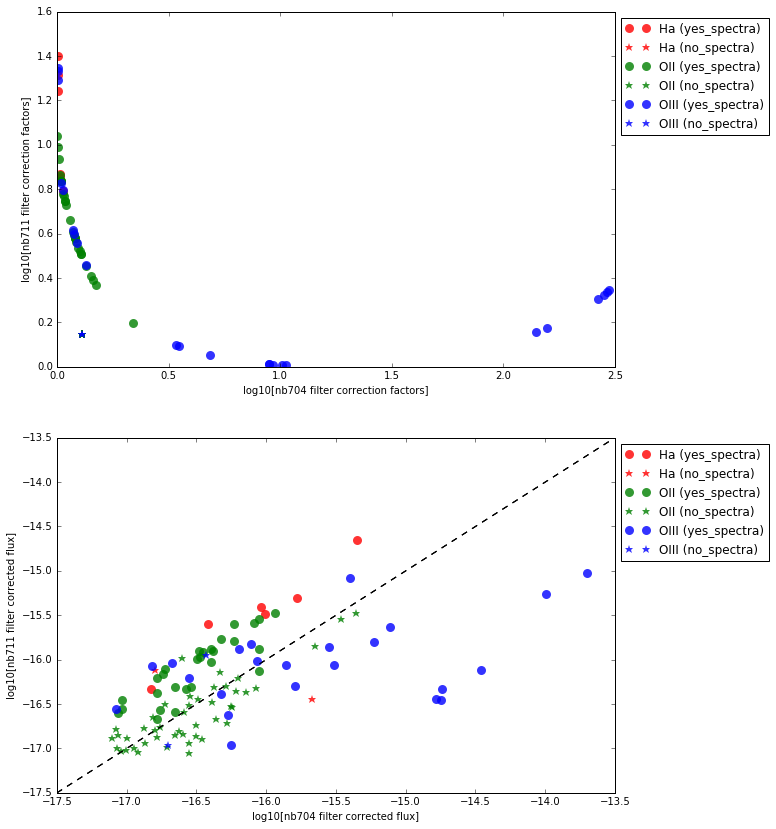

In [5]:
nb704_filt_corr_factors = np.zeros(len(dual))
nb711_filt_corr_factors = np.zeros(len(dual))

f, ax = plt.subplots(2,1)

for line, linecent, col in zip(['Ha', 'OII', 'OIII'], [6562.8, 3727.0, 5006.8], ['red','green','blue']):
    lmatch = np.array([x for x in range(len(dual)) if line+'-NB7' in NAME0[dual][x]])
    yz = lmatch[np.where((zspec0[dual[lmatch]] > 0) & (zspec0[dual[lmatch]] < 9))[0]]
    nz = lmatch[np.where((zspec0[dual[lmatch]] < 0) | (zspec0[dual[lmatch]] > 9))[0]]

    ## nb704 corrs
    # no spectra
    nb704_filt_corr_factors[nz] = np.log10(filter_stat_corr_dict['NB704'])
    
    # yes spectra
    z_filt1 = nb704_response['col1'].data/linecent - 1
    yresponse1 = np.array(nb704_response['col2'])
    f1 = interp1d(z_filt1, nb704_response['col2'])
    fcorr1 = np.log10(1.0/(f1(zspec0[dual[yz]])/max(yresponse1)))
    nb704_filt_corr_factors[yz] = fcorr1
    
    ## nb711 corrs
    # no spectra
    nb711_filt_corr_factors[nz] = np.log10(filter_stat_corr_dict['NB711'])
    
    # yes spectra
    z_filt2 = nb711_response['col1'].data/linecent - 1
    yresponse2 = np.array(nb711_response['col2'])
    f2 = interp1d(z_filt2, nb711_response['col2'])
    fcorr2 = np.log10(1.0/(f2(zspec0[dual[yz]])/max(yresponse2)))
    nb711_filt_corr_factors[yz] = fcorr2
    
    
    # plotting
    ax[0].plot(nb704_filt_corr_factors[yz], nb711_filt_corr_factors[yz], 
               c=col, marker='o', lw=0, alpha=0.8, ms=9, mew=0, label=line+' (yes_spectra)')
    ax[0].plot(nb704_filt_corr_factors[nz], nb711_filt_corr_factors[nz], 
               c=col, marker='*', lw=0, alpha=0.8, ms=9, mew=0, label=line+' (no_spectra)')
    ax[0].set_xlabel('log10[nb704 filter correction factors]')
    ax[0].set_ylabel('log10[nb711 filter correction factors]')
    ax[0].legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
    
    ax[1].plot(allcolsdata['NB704_FLUX'][dual[yz]]+nb704_filt_corr_factors[yz], 
               allcolsdata['NB711_FLUX'][dual[yz]]+nb711_filt_corr_factors[yz], 
               c=col, marker='o', lw=0, alpha=0.8, ms=9, mew=0, label=line+' (yes_spectra)')
    ax[1].plot(allcolsdata['NB704_FLUX'][dual[nz]]+nb704_filt_corr_factors[nz], 
               allcolsdata['NB711_FLUX'][dual[nz]]+nb711_filt_corr_factors[nz], 
               c=col, marker='*', lw=0, alpha=0.8, ms=9, mew=0, label=line+' (no_spectra)')
    ax[1].plot([-17.5,-13.5], [-17.5, -13.5], 'k--')
    ax[1].set_xlabel('log10[nb704 filter corrected flux]')
    ax[1].set_ylabel('log10[nb711 filter corrected flux]')
    ax[1].legend(loc='upper left', bbox_to_anchor=(1.0,1.0))

f.set_size_inches(10,14)

In [6]:
# quick histogram of the location of the emission lines vs NB704 and NB711 filters 
#  You would plot: (1+zspec) * [6562.8, 5006.8, or 3727]

[ 7040.57184  7043.85324  7046.47836  7064.19792  7060.91652  7061.5728 ]
[ 7078.3184  7062.2923  7061.1742  7062.2923  7062.2923  7058.1926
  7055.9564  7067.1374  7066.392   7064.9012  7077.573   7073.1006
  7074.5914  7074.5914  7074.5914  7098.4442  7073.846   7076.8276
  7083.9089  7075.3368  7081.3     7054.0929  7070.4917  7066.392
  7078.3184  7085.027   7065.2739  7086.5178]
[ 7165.73216  7165.23148  7073.60704  7163.72944  7164.7308   7121.67232
  7122.67368  7072.60568  7153.71584  7107.65328  7108.15396  7113.16076
  7155.21788  7062.59208  7064.09412  7044.5676   7043.06556  7123.17436
  7121.17164  7121.17164  7075.60976  7042.56488  7081.11724]


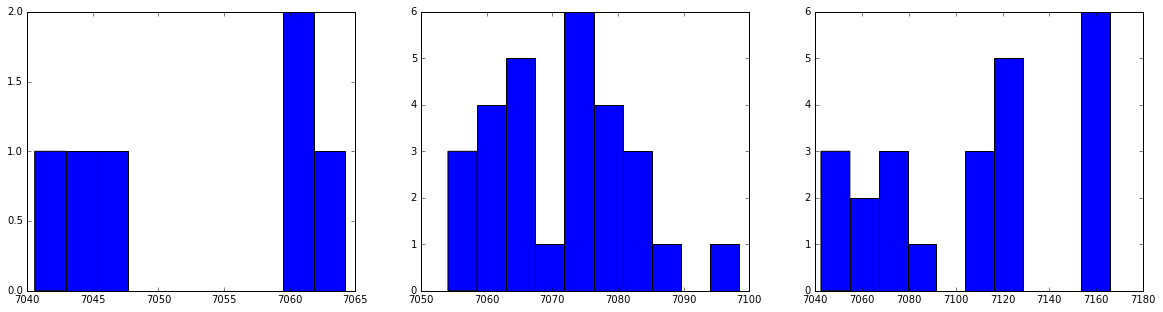

In [7]:
f, ax = plt.subplots(1,3)
for i, line, ltitle in zip(range(3), [6562.8, 3727.0, 5006.8], ['Ha', 'OII', 'OIII']):
    lmatch = np.array([x for x in range(len(dual)) if ltitle+'-NB7' in NAME0[dual][x]])
    yz = lmatch[np.where((zspec0[dual[lmatch]] > 0) & (zspec0[dual[lmatch]] < 9))[0]]
    print (1+zspec0[dual[yz]])*line
    ax[i].hist((1+zspec0[dual[yz]])*line)
    
f.set_size_inches(20,5)